# Welcome to the first part of the ML image analysis and classification workshop!

In this notebook you will do some basic analysis of the images in the dataset that we will analyse.

In [ ]:
# We start by running this cell to make sure that all relevant files are present in the folder structure
!git clone https://github.com/NordAxon/NBI-Handelsakademin-ML-Labs.git

# We move the Kaggle API token to where Colab wants it
!mkdir -p ~/.kaggle/ && mv NBI-Handelsakademin-ML-Labs/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

# We download the kaggle dataset
!kaggle datasets download -d suddirutten/covid-xray-modified

# And we unzip the dataset and put it in the image-lab folder :-)
import zipfile
with zipfile.ZipFile("/content/covid-xray-modified.zip","r") as zip_ref:
    zip_ref.extractall("/content/NBI-Handelsakademin-ML-Labs/image-lab")

In [10]:
# Run this cell to import all neccesary packages

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import cv2
import random
from collections import defaultdict

In [ ]:
# Run this cell to import 

In [16]:
! kaggle datasets download -d suddirutten/covid-xray-modified

'kaggle' is not recognized as an internal or external command,
operable program or batch file.


## 1) Analysis

### Your first task is to read in all images from the dataset and analyze them
We want you to read the images into one list and thus be able to find the sizes of the tensors (=images)

You should be able to answer the following questions after this exercise:

- What shapes are the images?
- How many images are there, per class, in the training and test set?
- There are 3 channels in each image, is this necessary? (I.e. is the data unique over the channels?)


In [3]:
# 



### Optional hints for solving the task:
- By using pathlib, we can glob our way through all images and find them immediately. Example: path_dir.rglob('*.xslx') finds all excel files (that end on .xslx) recursively in the path_dir
- Using the pathlib parent and name property, we can easily find the class and set of an image
- Saving the number of images found in a nested dict makes it easy to read (both code and output). Creating a nested dict is possible through dict_name = defaultdict(lambda: defaultdict(int)), or dict_name = {{}}. defaultdict is neat as we do not need to check for existing keys when handling the dict.
- Using cv2 we can read images into a numpy array

In [3]:
# ---------------- SOLUTION --------------------
# Point to dataset path
path_to_images = Path("../Covid19-dataset/raw")
# rglob through and make sure to get all file extensions
all_paths = list(path_to_images.rglob('*.jpeg')) + list(path_to_images.rglob('*.jpg')) + list(path_to_images.rglob('*.png'))

# Create empty list and empty dict
images_list = []
set_sizes = defaultdict(lambda: defaultdict(int))
# Loop thorugh each path that we have
for image_path in all_paths:
    # Find in what set the image lies (i.e. train or test)
    set_name = image_path.parent.parent.name
    # Find the class name (Pneumonia, Covid, Normal)
    image_class = image_path.parent.name
    # Increment the size of the current set
    set_sizes[set_name][image_class] += 1
    # Read the image
    image = cv2.imread(str(image_path))
    # Append the image path and the image to the images_list
    images_list.append((image_path, image))

# Print the set sizes and the images_list shape (by converting it to a numpy array and only looking at the images)
print(set_sizes)
print(np.asarray([tup[1] for tup in images_list]).shape)

# Loop through each image and see if all 3 channels contain the same information
for path, image in images_list:
    if not (image[:,:,0] == image[:,:,1]).all():
        print("The channels are not identical", path)
    if not (image[:,:,0] == image[:,:,2]).all():
        print("The channels are not identical", path)
    if not (image[:,:,2] == image[:,:,1]).all():
        print("The channels are not identical", path)
    

defaultdict(<function <lambda> at 0x0000026AA9C9A4C0>, {'test': defaultdict(<class 'int'>, {'Covid': 26, 'Normal': 20, 'Viral Pneumonia': 20}), 'train': defaultdict(<class 'int'>, {'Covid': 111, 'Normal': 70, 'Viral Pneumonia': 70})})
(317, 340, 410, 3)


## 2) Pre-processing
### Your second task is to apply some pre-processing techniques to your images
Assume that you have done a basic pixel value distribution analysis on the images and hypothesize that a contrast/brightness adjustment could be useful. To apply a transform like this you will use ready-to-go methods from opencv.

You will apply one pre-processing technique to one channel of each image, and save them in a separate folder. This folder will follow the folder structure as for the raw data, but instead lie in the folder "Covid19-dataset/processed"

You should be able to answer the following questions after this exercise:
- Looking at one picture, how did the pixel value distribution change after applying a CLAHE function to the image?
- What hyperparameters did you try? How did they affect the distribution and how the image looked?
- Do you think this pre-processing technique could aid an ML model when training?

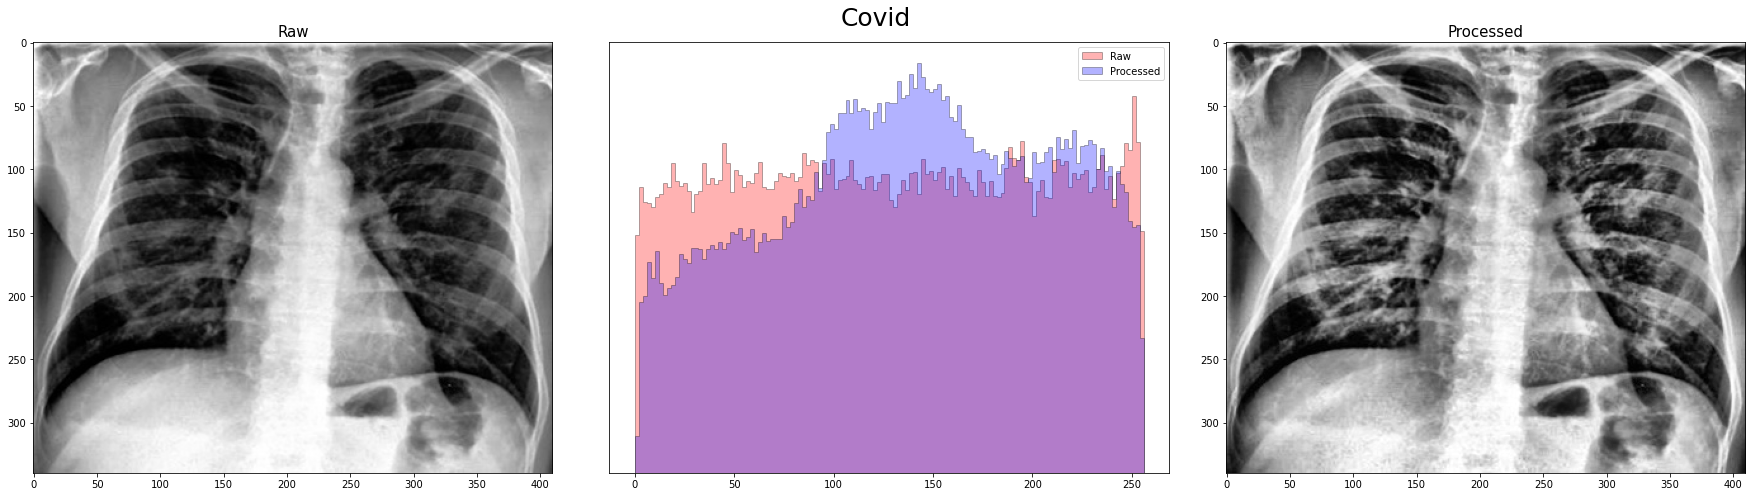

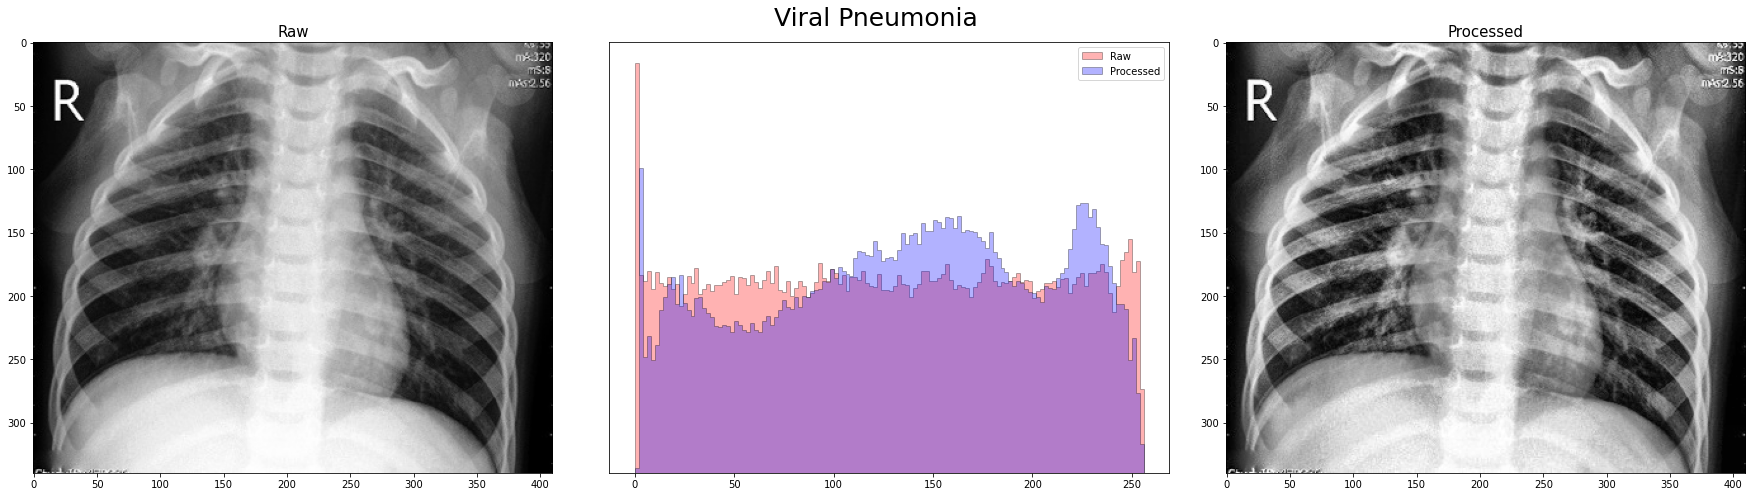

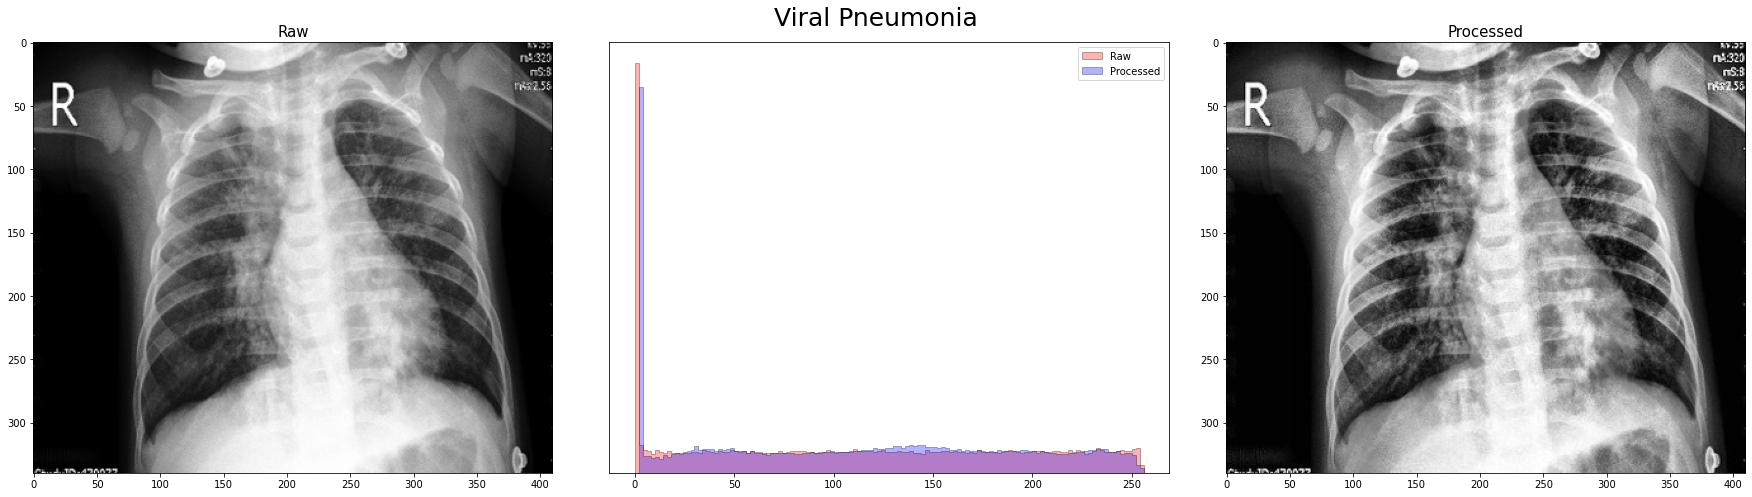

In [15]:
# ------------ SOLUTION -------------

def plot_nicely(img : np.ndarray, clahe_img: np.ndarray, title: str):
    """
        Function to do nice plots of img and clahe before, after and with img distr
    """
    # Arguments for nice hist plots
    kwargs = dict(bins=256//2, range=[0,256], histtype='stepfilled', alpha=0.3, ec="k", density=True)

    # Create subplots
    fig, ax = plt.subplots(1,3,figsize = (25,7))

    ax[0].imshow(img/255)
    ax[0].set_title("Raw", fontsize = 15)

    ax[1].hist(img[:,:,0].flatten(), color='r',  label="Raw", **kwargs)
    ax[1].hist(clahe_img.flatten(), color = 'b', label= "Processed", **kwargs)
    ax[1].set_yticks([])
    ax[1].legend()

    ax[2].imshow(clahe_img/255, cmap="gray")
    ax[2].set_title("Processed", fontsize = 15)

    fig.suptitle(title, fontsize = 25)
    fig.tight_layout()

# Pick k numbers of samples to plot
k = 3
to_plot = random.choices(images_list, k = k)
# Saving the CLAHE transformed images under processed
for path, img in images_list:
    # --- Applying clahe -----
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(img[:,:,0])

    if path in [path for path,img in to_plot]:
        plot_nicely(img, cl1, path.parent.name)

    # --- Saving new image under processed ----
    new_path = path.parents[3] / "processed" / path.parents[1].name / path.parent.name / path.name
    cv2.imwrite(str(new_path), cl1)